# Airbnb review sentiment analysis
This notebook demonstrates how to build a deep learning model to analyze sentiments of Airbnb reviews.

In [1]:
import tensorflow as tf
import pandas as pd
import re
from langdetect import detect
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

2025-04-30 13:25:20.982666: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 13:25:21.919234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 13:25:22.742506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746012323.409026   15033 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746012323.597629   15033 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746012325.207426   15033 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Librarys used and what there purpose is
- Tensorflow
    - Is used to build, and train our sequential nerual network for sentiment analysis, handels text vectorization that converts text into numerical data.
- Pandas
    - Is used to load the dataset and create the dataframe, also allows us to filter and create sampling dataset.
- langdetect
    - Used for detecting english reviews.
- numpy
    - Helps us to create the necessary np array for training.
-  sklearn
    - Used to split the data into training and test sets, and get a detailed classification report. 
-  re
    - Used for text cleaning, such as remove the html tags from the reviews.
-  matplotlib
    - Used to plot and illustrate the result of the training and model loss

In [2]:
# load the dataset
print("loading airbnb reviews dataset...")
df = pd.read_csv("reviews.csv")
print(f"Orginal dataset\n {df}")

loading airbnb reviews dataset...
Orginal dataset
                  listing_id                   id        date  reviewer_id  \
0                    164448               407660  2011-07-30       870312   
1                    164448               451097  2011-08-16       901633   
2                    164448               472271  2011-08-24       894674   
3                    164448               521708  2011-09-11       232485   
4                    164448               568347  2011-09-26       896712   
...                     ...                  ...         ...          ...   
144943  1305729897949100039  1317299844322463966  2024-12-22    666963478   
144944  1306393577432561110  1315873156254706149  2024-12-20    442177472   
144945  1310885179474906446  1316587888366107935  2024-12-21     53058534   
144946  1312171107579620356  1320280905319488958  2024-12-26    595482193   
144947  1316786620019656619  1322401494741586698  2024-12-29    135251598   

       reviewer_name    

# Data cleaning

In [3]:
# Clean html tags
def clean_html(text):
    if isinstance(text, str):
        return re.sub(r"<.*?>", "", text)
    return text

In [4]:
# Remove the empty comments rows
df = df.dropna(subset=["comments"])
df["comments"] = df["comments"].apply(clean_html)
print(f"After remoing empty comments\n {df}")

After remoing empty comments
                  listing_id                   id        date  reviewer_id  \
0                    164448               407660  2011-07-30       870312   
1                    164448               451097  2011-08-16       901633   
2                    164448               472271  2011-08-24       894674   
3                    164448               521708  2011-09-11       232485   
4                    164448               568347  2011-09-26       896712   
...                     ...                  ...         ...          ...   
144943  1305729897949100039  1317299844322463966  2024-12-22    666963478   
144944  1306393577432561110  1315873156254706149  2024-12-20    442177472   
144945  1310885179474906446  1316587888366107935  2024-12-21     53058534   
144946  1312171107579620356  1320280905319488958  2024-12-26    595482193   
144947  1316786620019656619  1322401494741586698  2024-12-29    135251598   

       reviewer_name                         

In [5]:
# Filter out the rows that isn't in English
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False
    
df["is_english"] = df["comments"].apply(is_english)
df = df[df["is_english"]]
print(f"After removing non-english comments\n {df}")

After removing non-english comments
                  listing_id                   id        date  reviewer_id  \
0                    164448               407660  2011-07-30       870312   
1                    164448               451097  2011-08-16       901633   
2                    164448               472271  2011-08-24       894674   
3                    164448               521708  2011-09-11       232485   
4                    164448               568347  2011-09-26       896712   
...                     ...                  ...         ...          ...   
144935  1298347645930946959  1307248295819579395  2024-12-08    479920506   
144938  1301950247646962698  1316668854181848371  2024-12-21     34223838   
144940  1302247401950369176  1307146471377559196  2024-12-08      1922353   
144942  1304284803854492401  1307949554237811713  2024-12-09     86342696   
144944  1306393577432561110  1315873156254706149  2024-12-20    442177472   

       reviewer_name                  

# Simple sentiment analysis
Creating initial sentiment labels using a word based approach

In [6]:
positive_words = [
    "great", "good", "nice", "excellent", "perfect", "happy", "wonderful", 
    "fantastic", "amazing", "love", "best", "beautiful", "clean", "comfortable",
    "helpful", "recommend", "enjoyed", "pleasant", "delightful", "convenient",
    "friendly", "impressed", "satisfied", "superb", "lovely", "exceptional",
    "outstanding", "brilliant", "spotless", "spacious", "convenient", "ideal",
    "charming", "cozy", "luxurious", "modern", "stylish", "relaxing", "peaceful"
]

negative_words = [
    "bad", "poor", "terrible", "horrible", "awful", "worst", "dirty", 
    "disappointing", "disappointment", "uncomfortable", "problem", "not clean", "broken",
    "issue", "issues", "annoying", "noisy", "small", "expensive", "overpriced",
    "rude", "unpleasant", "unhelpful", "disgusting", "outdated", "smelly",
    "misleading", "stained", "cramped", "cold", "hot", "bugs", "cockroaches",
    "musty", "mold", "mildew", "rundown", "unsafe", "sketchy", "dusty"
]

In [7]:
def simple_sentiment(text):
    if not isinstance(text, str):
        return 1
    
    text = text.lower()
    pos_count = sum(1 for word in positive_words if word in text)
    neg_count = sum(1 for word in negative_words if word in text)

    negations = ["not", "isn't", "aren't", "wasn't", "weren't", "don't", "doesn't", 
                "didn't", "can't", "couldn't", "shouldn't", "wouldn't", "no", "never"]
    # Example: The floor was not dirty.
    for neg in negations:
        neg_pattern = f"{neg}"
        if neg_pattern in text:
            for i, word in enumerate(positive_words):
                if f"{neg} {word}" in text:
                    pos_count -= 1
                    neg_count += 1

    if neg_count > pos_count * 0.7:
        return "NEGATIVE" 
    else:
        return "POSITIVE"

In [8]:
# create simple labels
df["sentiment_label"] = df["comments"].apply(simple_sentiment)

In [9]:
# Print distribution of initial labels
print("\nInitial sentiment distribution:")
label_counts = df["sentiment_label"].value_counts()
print(label_counts)
print(f"Positive percentage: {label_counts[1]/len(df)*100:.2f}%")


Initial sentiment distribution:
sentiment_label
POSITIVE    95933
NEGATIVE     3770
Name: count, dtype: int64
Positive percentage: 3.78%


/tmp/ipykernel_15033/2134060337.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Positive percentage: {label_counts[1]/len(df)*100:.2f}%")


# Handle class imbalance
Balancing the dataset to improve model training:

In [10]:
#Convert sentiment labels to numeric values
df["sentiment_numeric"] = df["sentiment_label"].map({"POSITIVE": 1, "NEGATIVE": 0})

In [11]:
# Handle class imbalance
positive_samples = df[df["sentiment_numeric"] == 1]
negative_samples = df[df["sentiment_numeric"] == 0]

In [12]:
# get some number of positive samples as negative samples
positive_down_sampled = positive_samples.sample(n=len(negative_samples) * 3, random_state=42)
balanced_df = pd.concat([positive_down_sampled, negative_samples])

print(f"\nBalanced dataset shape: {balanced_df.shape}")
print("Balanced sentiment distribution:")
print(balanced_df['sentiment_label'].value_counts())


Balanced dataset shape: (15080, 9)
Balanced sentiment distribution:
sentiment_label
POSITIVE    11310
NEGATIVE     3770
Name: count, dtype: int64


# Split the data
Creating training and testing datasets:

In [13]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    balanced_df["comments"],
    balanced_df["sentiment_numeric"],
    test_size=0.2,
    stratify=balanced_df["sentiment_numeric"],
    random_state=42
)

print(f"Training set size: {len(x_train)}")
print(f"Test set size: {len(x_test)}")

Training set size: 12064
Test set size: 3016


# Text Preprocessing
Creating a text vectorization layer:

In [14]:
#create a text vectorization layer
max_features = 15000
sequence_length = 300

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)


E0000 00:00:1746012720.300790   15033 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746012720.342404   15033 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
vectorize_layer.adapt(x_train.values)

# Build the model
Creating a nerual network for sentiment classification:

In [16]:
# build the model
embedding_dim = 16

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(max_features + 1,embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [17]:
# compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model
Training the sentiment analysis model:

In [18]:
# Train the model
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.dtype, y_train.dtype)


history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

object int64
Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7481 - loss: 0.5508 - val_accuracy: 0.7613 - val_loss: 0.5250
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7558 - loss: 0.5297 - val_accuracy: 0.7717 - val_loss: 0.5098
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7724 - loss: 0.5100 - val_accuracy: 0.7812 - val_loss: 0.4988
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7694 - loss: 0.5113 - val_accuracy: 0.7882 - val_loss: 0.4899
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7818 - loss: 0.4904 - val_accuracy: 0.7882 - val_loss: 0.4720
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7800 - loss: 0.4759 - val_accuracy: 0.8002 - val_loss: 0.4610
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7924 - loss: 0.4555 - val_accuracy: 0.8015 - val_loss: 0.4338
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8113 - loss: 0.4238 - val

# Evaluate the model
Testing the models performance:

In [19]:
# eval model

x_test = np.array(x_test.tolist()) if isinstance(x_test, np.ndarray) else np.array(x_test)
y_test = np.array(y_test.tolist()) if isinstance(y_test, np.ndarray) else np.array(y_test)


loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8426 - loss: 0.3876
Test accuracy: 0.8352


# Analyze model performance
Generating a classification report to understand model strengths and weaknessess:

In [20]:
# predict and analyse
predictions = model.predict(x_test)
binary_predictions = (predictions > 0.5).astype(int)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [21]:
# print classification report, 0 = negative, 1 = true
print("Classification report:")
print(classification_report(y_test, binary_predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.46      0.58       754
           1       0.84      0.96      0.90      2262

    accuracy                           0.84      3016
   macro avg       0.82      0.71      0.74      3016
weighted avg       0.83      0.84      0.82      3016



## Understand the classification report
- 0: Is the negative reviews
- 1: Is the positive reviews
- Precision: when the model predicts a particular class, how often is it correct.
- Recall: Of all actual instances of a class, how many did the model correctly identify
- f1-score: Mean of precision and recall
- Support: Number of occurrences of each class in the test
- Accuracy: How much the model is correct overall
- Macro avg: Simple average of metrics across classes
- Weighted avg: Average weigthed by the number of samples in each class 


# Visualize traning history
Creating visualizations of model training process:

Saved training history to 'training_history.png'


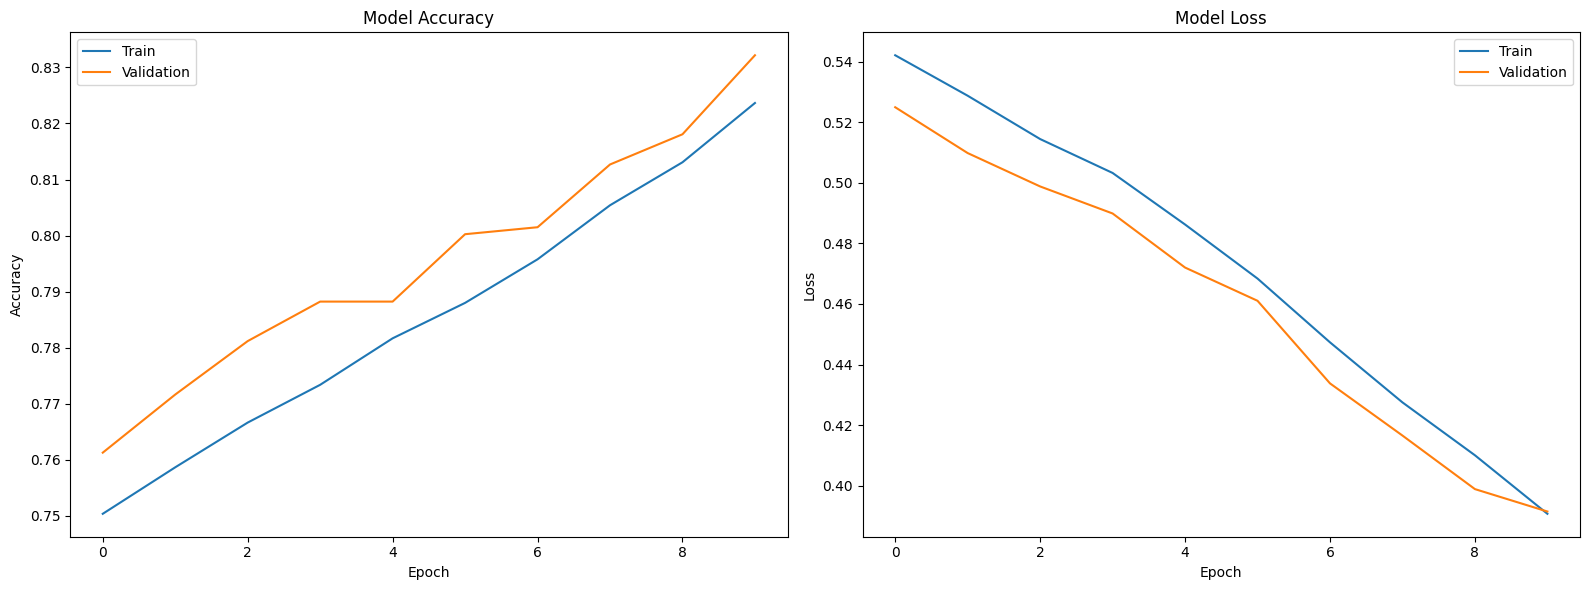

In [22]:
# visualize traning history
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.savefig('training_history.png')
print("Saved training history to 'training_history.png'")

In [23]:
# save the model
model.save("airbnb_sentiment_model.keras")
print("Model saved to 'airbnb_sentiment_model'")

Model saved to 'airbnb_sentiment_model'


# Apply model to full dataset
Using the trained model to classify sentiments in the original dataset:

In [24]:
# apply model to full dataset
export_model = tf.keras.Sequential([
    vectorize_layer,
    model.layers[1],
    model.layers[2],
    model.layers[3],
    model.layers[4],
    model.layers[5]
])

In [25]:
# sample the data if its to large
sample_size = min(10000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

In [26]:
# apply the model to the sampled data
df_sample['ml_sentiment_score'] = export_model.predict(df_sample['comments'].astype(str).values)
df_sample['ml_sentiment'] = (df_sample['ml_sentiment_score'] > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [27]:
df_sample["ml_sentiment_label"] = df_sample["ml_sentiment"].map({1: "POSITIVE", 0: "NEGATIVE"})
output_columns = ["listing_id", "id", "date", "reviewer_id", "reviewer_name", "comments", "ml_sentiment_score", "ml_sentiment_label"]
df_sample[output_columns].to_csv("classified_reviews_ml.csv", index=False)

print("\nSaved classified reviews to 'classified_reviews_ml.csv'")
print("Sample of the output:")
print(df_sample[output_columns].head())


Saved classified reviews to 'classified_reviews_ml.csv'
Sample of the output:
                listing_id                   id        date  reviewer_id  \
34210             17006375            267057228  2018-05-21    172659742   
108650  638919039053498732   699779342342681157  2022-08-23    159266526   
1098                299154             21769773  2014-10-23     22280153   
48218             23018619            296981110  2018-07-27    151951125   
105173  575197509951881015  1248481463453560455  2024-09-18    410890762   

       reviewer_name                                           comments  \
34210         Laurie  This was a very clean and comfortable apartmen...   
108650   Marie-Laure           Stockholm is a great capital to live in.   
1098          Tereza  Daniels apartment is in very nice neiborhood w...   
48218       Slawomir  stylish place to stay with nice garden,easy ac...   
105173         Jayma  The location of this beautiful apartment was u...   

        ml_se